# Buffered pH Dynamics

With some inspiration from Glaser _et al_ (2014) https://doi.org/10.1021/ed400808c. Core approach
is to model the mass-action kinetics of proton dissociation/association in water plus an arbitrary
number of other sites with specified $pK_a$s.

All are modeled as _dissociation_ reactions, ${HA} \rightleftharpoons A^- + H^+$. So:
- $v_f = k_f [HA]$
- $v_b = k_b [H^+] [A^-]$
- $K_a = k_f / k_b$
- $pK_a = -log_{10}(K_a)$

where _f_ subscripts refer to forward reaction, and _b_ to back.

In general, $pK_a$ is measured, but $k_f$ and $k_b$ are not independently known. In the absence of other information we will assume a constant value for $k_b$, with the rationale that it is dominated by frequency of collistion with $H^+$.

In [1]:
import projectpath

from dataclasses import dataclass
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize

from mosmo.knowledge import kb
from mosmo.model import KbEntry, Molecule

jax.config.update('jax_enable_x64', True)
KB = kb.configure_kb()

## From Glaser _et al_, malic acid system

In [2]:
water = KB.get(KB.CHEBI, '15377')
proton = KB.get(KB.CHEBI, '24636')
hydroxide = KB.get(KB.CHEBI, '16234')

malic = KB.get(KB.CHEBI, '30797')  # L-malate,  fully protonated
malate_m2 = KB.get(KB.CHEBI, '15589')  # L-malate 2-

# Not even CHEBI defines monoprotonated L-malate 1- (at either site). 
# Glaser et al refers only to a single HA-, i.e. they assume the more acidic group _always_ dissociates first.
# We might explore this assumption below, but for now follow their lead.
malate_m1 = Molecule(
    _id='malate.L.1-',
    name='L-malate(1-)',
    formula='C4H5O5',
    mass=133.08,
    charge=-1,
)

@dataclass
class Deprotonation:
    id: str
    acid: Molecule
    base: Molecule
    pKa: float

deprotonations = [
    Deprotonation('auto', water, hydroxide, 14.0),
    Deprotonation('h1', malic, malate_m1, 3.46),
    Deprotonation('h2', malate_m1, malate_m2, 5.10),
]
deprotonations

[Deprotonation(id='auto', acid=[15377] water, base=[16234] hydroxide, pKa=14.0),
 Deprotonation(id='h1', acid=[30797] (S)-malic acid, base=[malate.L.1-] L-malate(1-), pKa=3.46),
 Deprotonation(id='h2', acid=[malate.L.1-] L-malate(1-), base=[15589] (S)-malate(2-), pKa=5.1)]

One thing to explore: The treatment of water as both a solvent and a reactant is, if not controversial, then at least subject to confusion (see [What is the pKa of water?](https://chem.libretexts.org/Bookshelves/Organic_Chemistry/Supplemental_Modules_(Organic_Chemistry)/Fundamentals/What_is_the_pKa_of_water)). 

To work consistently, we must satisfy (for water)
- $pK_a = 14.0 \Longrightarrow K_a = 10^{-14}$
- $\frac{k_f}{k_b} = K_a \Longrightarrow k_f = k_b K_a$
- At equilibrium, $k_f[H_2O] = k_b[H^+][OH^-]$

As discussed in that article, this only works if $[H_2O]$ _i.e._ the _activity_ of water is defined to be 1 (not its concentration, which is ~55 M). This is consistent with the common definition of $K_a = [H^+][OH^-] = 10^{-14}$, "leaving out" the substrate (acid) $[H_2O]$ from the denominator of the equilibrium constant. As the author describes it, $[H_2O]$ is not left out so much as we simply ignore the effect of dividing by 1.

For our purposes, the most important point is that $v_f = k_f[H_2O]$ and $v_b = k_b[H^+][OH^-]$ are consistent with measured pH values, iff we take $[H_2O] = 1$. I can reconcile this in my head by saying everything is baked into conventions and how we define reference points, although it does stand in the way of interpreting the first-order $k_f$ as an intrinsic _per molecule_ decay rate.


In [3]:
DEFAULT_KBACK = 1e9  # per Molar per sec.  TODO: reference/justification for this value
pH = 7.0

# 0.1 M malic acid in water.
concs = {
    water: 1.0,  # Activity of the solvent defined as 1.
    proton: pow(10, -pH),
    hydroxide: pow(10, pH - 14),
    malic: 0.1,
    malate_m1: 0,
    malate_m2: 0,
}

mols = list(concs.keys())
acids_idx = np.array([mols.index(d.acid) for d in deprotonations])
bases_idx = np.array([mols.index(d.base) for d in deprotonations])
proton_idx = mols.index(proton)

s_matrix = np.zeros((len(mols), len(deprotonations)))
for i, d in enumerate(deprotonations):
    s_matrix[mols.index(d.acid), i] = -1
    s_matrix[mols.index(d.base), i] = 1
    s_matrix[mols.index(proton), i] = 1

pK_a = np.array([d.pKa for d in deprotonations])
K_a = np.power(10, -pK_a)  # Molar
k_f = K_a * DEFAULT_KBACK  # per sec
k_b = np.full_like(k_f, DEFAULT_KBACK)

def dydt(y):
    vf = k_f * y[acids_idx]
    vb = k_b * y[proton_idx] * y[bases_idx]
    vnet = vf - vb
    return s_matrix @ vnet


## Simulate Forward (solve_ivp)

In [4]:
fn = jax.jit(dydt)
jac = jax.jit(jax.jacfwd(dydt))

y0 = jnp.array([concs[mol] for mol in mols])
t = np.linspace(0, 0.0001, 1001)  # pH is fast
sim = scipy.integrate.solve_ivp(
    fun=lambda _, y: fn(y),
    jac=lambda _, y: jac(y),
    y0=y0,
    t_span=(0, 0.001),
    t_eval=t,
    method='BDF',
    first_step=1e-9,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
df = pd.DataFrame(sim.y.T, index=t, columns=[mol.name for mol in mols])
df

,water,proton,hydroxide,(S)-malic acid,L-malate(1-),(S)-malate(2-)
0.000000e+00,1.0,1.000000e-07,1.000000e-07,0.100000,0.000000,0.000000
1.000000e-07,1.0,3.067378e-03,8.491093e-08,0.096934,0.003065,0.000001
2.000000e-07,1.0,4.761677e-03,5.662610e-08,0.095242,0.004755,0.000003
3.000000e-07,1.0,5.406015e-03,3.382121e-08,0.094599,0.005395,0.000005
4.000000e-07,1.0,5.624396e-03,1.946971e-08,0.094382,0.005612,0.000006
...,...,...,...,...,...,...
9.960000e-05,1.0,5.725546e-03,1.742254e-12,0.094282,0.005710,0.000008
9.970000e-05,1.0,5.725546e-03,1.742261e-12,0.094282,0.005710,0.000008
9.980000e-05,1.0,5.725546e-03,1.742268e-12,0.094282,0.005710,0.000008
9.990000e-05,1.0,5.725546e-03,1.742275e-12,0.094282,0.005710,0.000008


## Find Steady State by Gradient Descent

- Same fn, same jacobian, same y0 (because why not)


In [6]:
soln = scipy.optimize.least_squares(
    fun=fn,
    jac=jac,
    x0=y0,
    verbose=2,
    xtol=1e-15,
)
soln

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8034e+09                                    3.61e+10    
       1              4         2.4940e+08      1.55e+09       6.28e-02       1.34e+10    
       2              6         1.2788e+06      2.48e+08       3.14e-02       4.74e+09    
       3             11         3.3760e+05      9.41e+05       2.45e-04       2.32e+09    
       4             12         2.4003e+05      9.76e+04       4.91e-04       2.08e+09    
       5             14         3.9185e+04      2.01e+05       1.23e-04       6.88e+08    
       6             16         4.9598e+03      3.42e+04       6.13e-05       1.87e+08    
       7             18         1.5982e+02      4.80e+03       3.07e-05       3.37e+07    
       8             21         3.2528e+01      1.27e+02       3.83e-06       1.54e+07    
       9             23         5.1884e+00      2.73e+01       1.92e-06       6.15e+06    

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.085e-10 -6.934e-11  2.085e-10  1.212e-10  3.544e-11
               -1.566e-10]
           x: [ 1.000e+00  1.941e-03  5.153e-12  5.754e-03  1.028e-03
                4.208e-06]
        cost: 6.609019601363514e-20
         jac: [[-1.000e-05  5.153e-03 ...  0.000e+00  0.000e+00]
               [ 1.000e-05 -1.032e+06 ... -1.933e+06 -1.941e+06]
               ...
               [ 0.000e+00 -1.024e+06 ... -1.949e+06  1.941e+06]
               [ 0.000e+00 -4.208e+03 ...  7.943e+03 -1.941e+06]]
        grad: [ 3.476e-15  1.605e-04 -6.745e-04 -5.377e-05  2.989e-04
                5.073e-04]
  optimality: 0.0006745408767412285
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00]
        nfev: 66
        njev: 28

Wait, that's not right. The issue is that nothing conserves the total (malic acid + malate(1-) + malate(2-)). In the forward sim the s_matrix ensures this conservation. In an optimization we need to do it another way.


In [7]:
# Too clever by half: What we optimize is the net integrated flux per Deprotonation
def dydt_from_events(x):
    y = y0 + s_matrix @ x
    return dydt(y)

soln = scipy.optimize.least_squares(
    fun=jax.jit(dydt_from_events),
    jac=jax.jit(jax.jacfwd(dydt_from_events)),
    x0=jnp.zeros(s_matrix.shape[1]),
    xtol=1e-15,
    verbose=2,
)
soln

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8034e+09                                    3.61e+10    
       1              5         1.0538e+09      7.50e+08       2.69e-03       4.55e+11    
       2              6         6.8833e+08      3.65e+08       4.63e-03       9.63e+11    
       3              7         6.2667e+06      6.82e+08       1.43e-03       7.43e+10    
       4              8         1.2113e+03      6.27e+06       1.69e-04       1.00e+09    
       5              9         5.0599e-05      1.21e+03       2.42e-06       2.05e+05    
       6             10         8.9659e-20      5.06e-05       4.96e-10       8.62e-03    
       7             11         5.0247e-24      8.97e-20       2.11e-17       6.47e-05    
       8             12         5.0247e-24      0.00e+00       0.00e+00       6.47e-05    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 1.8034e+0

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.028e-17  1.826e-12  1.028e-17 -1.830e-12  1.834e-12
               -4.229e-15]
           x: [-1.000e-07  5.718e-03  7.921e-06]
        cost: 5.024688348873446e-24
         jac: [[ 5.726e+06  1.747e-03  1.747e-03]
               [-1.144e+07 -1.178e+07 -5.726e+06]
               ...
               [-5.702e+06 -1.178e+07  5.757e+06]
               [-7.921e+03  2.198e+01 -5.741e+06]]
        grad: [-4.181e-05 -6.469e-05  1.598e-07]
  optimality: 6.469155255282102e-05
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 12
        njev: 8

In [8]:
pd.Series(y0 + s_matrix @ soln.x, index=[mol.name for mol in mols])

water             1.000000e+00
proton            5.725546e-03
hydroxide         1.746558e-12
(S)-malic acid    9.428237e-02
L-malate(1-)      5.709704e-03
(S)-malate(2-)    7.921303e-06
dtype: float64

In [9]:
df.iloc[-1]

water             1.000000e+00
proton            5.725546e-03
hydroxide         1.742282e-12
(S)-malic acid    9.428237e-02
L-malate(1-)      5.709704e-03
(S)-malate(2-)    7.921304e-06
Name: 0.0001, dtype: float64

Noice

In [10]:
-np.log10((y0 + s_matrix @ soln.x)[proton_idx])

2.242183063133049

Which agrees with Glaser et al for dilute malic acid, 1e-1 M.

### Consolidate into a PhBuffer class

In [11]:
class PhBuffer:
    def __init__(self, components):
        # Water and its dissociation are always part of dynamics
        mols = ['H+', 'H2O', 'OH-']
        acids_idx = [1]
        bases_idx = [2]
        kas = [1e-14]
        
        for mol, pKas in components.items():
            start = len(mols)
            mols.append(mol)
            for i, pKa in enumerate(pKas):
                mols.append(f'{mol}(-{i + 1})')
                acids_idx.append(start + i)
                bases_idx.append(start + i + 1)
                kas.append(pow(10, -pKa))
        
        self.mols = mols
        self.acids_idx = np.array(acids_idx)
        self.bases_idx = np.array(bases_idx)
        
        self.kf = np.array(kas) * DEFAULT_KBACK
        self.kb = np.full_like(self.kf, DEFAULT_KBACK)

        # Use an S matrix just like any other reaction network. TODO: slicker ops eploiting known sparsity?
        self.s_matrix = np.zeros((len(mols), len(kas)))
        cols = np.arange(self.s_matrix.shape[1])
        self.s_matrix[self.acids_idx, cols] = -1  # all dissociations consume the acid
        self.s_matrix[self.bases_idx, cols] = 1   # all dissociations produce the base
        self.s_matrix[0, cols] = 1  # all dissociations produce a proton

    def state_vector(self, pH, concs):
        values = [pow(10, -pH), 1, pow(10, pH - 14)]
        for mol in self.mols[3:]:
            values.append(concs.get(mol, 0))
        return jnp.array(values)
    
    def rates(self, y):
        vf = self.kf * y[self.acids_idx]
        vb = self.kb * y[0] * y[self.bases_idx]
        return vf, vb
    
    def dydt(self, y):
        vf, vb = self.rates(y)
        vnet = vf - vb
        return self.s_matrix @ vnet
    
    def simulate(self, pH, concs, end, step=1e-7):
        fn = jax.jit(self.dydt)
        jac = jax.jit(jax.jacfwd(self.dydt))

        return scipy.integrate.solve_ivp(
            fun=lambda _, y: fn(y),
            jac=lambda _, y: jac(y),
            y0=self.state_vector(pH, concs),
            t_span=(0, end),
            t_eval=np.linspace(0, end, int(end / step) + 1),
            method='BDF',
            first_step=1e-9,  # pH is fast
        )
    
    def titrate(self, pH, concs, **kwargs):
        y0 = self.state_vector(pH, concs)
        proton_onehot = np.eye(self.s_matrix.shape[0])[0]

        def project_state(x):
            proton_ex = proton_onehot * x[0]
            dissociations = self.s_matrix @ x[1:]
            return y0 + dissociations + proton_ex
        
        def residual(x):
            y = project_state(x)
            dydt = self.dydt(y)
            return jnp.append(dydt, y[0] - y0[0])
        
        soln = scipy.optimize.least_squares(
            fun=jax.jit(residual),
            jac=jax.jit(jax.jacfwd(residual)),
            x0=jnp.zeros(1 + self.s_matrix.shape[1]),
            **kwargs
        )
        
        result = {m: v for m, v in zip(self.mols, np.asarray(project_state(soln.x)))}
        return result, soln        


In [12]:
buffer = PhBuffer({'malate': [3.46, 5.10]})
sim = buffer.simulate(7.0, {'malate': 0.1}, 0.0001)
pd.DataFrame(sim.y.T, index=sim.t, columns=[buffer.mols])

,H+,H2O,OH-,malate,malate(-1),malate(-2)
0.000000e+00,1.000000e-07,1.0,1.000000e-07,0.100000,0.000000,0.000000
1.000000e-07,3.067378e-03,1.0,8.491093e-08,0.096934,0.003065,0.000001
2.000000e-07,4.761677e-03,1.0,5.662610e-08,0.095242,0.004755,0.000003
3.000000e-07,5.406015e-03,1.0,3.382121e-08,0.094599,0.005395,0.000005
4.000000e-07,5.624396e-03,1.0,1.946971e-08,0.094382,0.005612,0.000006
...,...,...,...,...,...,...
9.960000e-05,5.725546e-03,1.0,1.746435e-12,0.094282,0.005710,0.000008
9.970000e-05,5.725546e-03,1.0,1.746448e-12,0.094282,0.005710,0.000008
9.980000e-05,5.725546e-03,1.0,1.746461e-12,0.094282,0.005710,0.000008
9.990000e-05,5.725546e-03,1.0,1.746474e-12,0.094282,0.005710,0.000008


In [13]:
buffer.titrate(7.0, {'malate': 0.1}, xtol=1e-15)

({'H+': 1.0000000000287557e-07,
  'H2O': 1.0,
  'OH-': 1e-07,
  'malate': 3.58562715754851e-07,
  'malate(-1)': 0.001243269067528932,
  'malate(-2)': 0.09875637236975532},
      message: `xtol` termination condition is satisfied.
      success: True
       status: 3
          fun: [-2.898e-10  2.876e-16 -2.876e-16  5.925e-12  2.780e-10
                -2.839e-10  2.876e-18]
            x: [-1.988e-01  6.091e-24  1.000e-01  9.876e-02]
         cost: 1.2095403704011514e-19
          jac: [[-1.000e+08 -1.000e+08 -1.003e+08 -1.000e+08]
                [ 1.000e+02  2.000e+02  1.000e+02  1.000e+02]
                ...
                [-9.876e+07 -9.876e+07 -9.875e+07 -9.876e+07]
                [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00]]
         grad: [ 8.413e-02  8.413e-02  8.413e-02  8.414e-02]
   optimality: 0.08414067096385917
  active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
         nfev: 5
         njev: 5)

## Glutamate (+Phosphate, +Glutathione, ...)

In [14]:
buffer = PhBuffer({
    'glu': [2.10, 4.07, 9.47],
    'pi': [1.97, 6.82, 12.5],
})

concs, details = buffer.titrate(7.3, {'glu': 0.096, 'pi': 0.024})
concs

{'H+': 5.0118723338155036e-08,
 'H2O': 1.0,
 'OH-': 1.9952623139795223e-07,
 'glu': 3.5407150822397426e-10,
 'glu(-1)': 5.6116552372850736e-05,
 'glu(-2)': 0.09529957886522757,
 'glu(-3)': 0.000644304228328071,
 'pi': 2.792465656625831e-08,
 'pi(-1)': 0.005970185709941768,
 'pi(-2)': 0.01802967260585814,
 'pi(-3)': 1.1375954352380949e-07}

In [15]:
sum(v for m, v in concs.items() if m.startswith('glu'))

0.096

In [16]:
sum(v for m, v in concs.items() if m.startswith('pi'))

0.024

In [17]:
-np.log10(concs['H+'])

7.3000000002129255

### A second titration from the end state of the first avoids some numerical precision issues

Which means maybe rethink the optimization to avoid the issues in the first place, if possible

In [18]:
-np.log10(buffer.titrate(7.3, concs, xtol=1e-15)[0]['H+'])

7.3

**Simpler**: optimize the vector of net integrated dissociation fluxes, but hold H+ (i.e. pH) constant.

Also, key everything on (mol, charge) tuples -- more intuitive to work with

In [19]:
class PhBuffer:
    def __init__(self, components):
        # Water and its dissociation are always part of dynamics
        mols = [('H', 1), ('H2O', 0), ('OH', -1)]
        acids_idx = [1]
        bases_idx = [2]
        kas = [1e-14]
        
        for (mol, charge), pKas in components.items():
            start = len(mols)
            mols.append((mol, charge))
            for i, pKa in enumerate(pKas):
                mols.append((mol, charge - i - 1))
                acids_idx.append(start + i)
                bases_idx.append(start + i + 1)
                kas.append(pow(10, -pKa))
        
        self.mols = mols
        self.acids_idx = np.array(acids_idx)
        self.bases_idx = np.array(bases_idx)
        
        self.kf = np.array(kas) * DEFAULT_KBACK
        self.kb = np.full_like(self.kf, DEFAULT_KBACK)

        # Use an S matrix just like any other reaction network. TODO: slicker ops eploiting known sparsity?
        self.s_matrix = np.zeros((len(mols), len(kas)))
        cols = np.arange(self.s_matrix.shape[1])
        self.s_matrix[self.acids_idx, cols] = -1  # all dissociations consume the acid
        self.s_matrix[self.bases_idx, cols] = 1   # all dissociations produce the base
        self.s_matrix[0, cols] = 1  # all dissociations produce a proton

    def state_vector(self, pH, concs):
        values = [pow(10, -pH), 1, pow(10, pH - 14)]
        for mol in self.mols[3:]:
            values.append(concs.get(mol, 0))
        return jnp.array(values)
    
    def rates(self, y):
        vf = self.kf * y[self.acids_idx]
        vb = self.kb * y[0] * y[self.bases_idx]
        return vf, vb
    
    def dydt(self, y):
        vf, vb = self.rates(y)
        vnet = vf - vb
        return self.s_matrix @ vnet
    
    def titrate(self, pH, concs, **kwargs):
        y0 = self.state_vector(pH, concs)

        def project_state(x):
            dissociations = self.s_matrix @ x
            y = y0 + dissociations
            return y.at[0].set(y0[0])
        
        def residual(x):
            y = project_state(x)
            dydt = self.dydt(y)
            return dydt
        
        soln = scipy.optimize.least_squares(
            fun=jax.jit(residual),
            jac=jax.jit(jax.jacfwd(residual)),
            x0=jnp.zeros(self.s_matrix.shape[1]),
            **kwargs
        )
        
        result = {m: v for m, v in zip(self.mols, np.asarray(project_state(soln.x)))}
        return result, soln        
    
    def simulate(self, pH, concs, end, step=1e-7):
        fn = jax.jit(self.dydt)
        jac = jax.jit(jax.jacfwd(self.dydt))

        return scipy.integrate.solve_ivp(
            fun=lambda _, y: fn(y),
            jac=lambda _, y: jac(y),
            y0=self.state_vector(pH, concs),
            t_span=(0, end),
            t_eval=np.linspace(0, end, int(end / step) + 1),
            method='BDF',
            first_step=1e-9,  # pH is fast
        )


In [20]:
buffer = PhBuffer({
    ('glu', +1): [2.10, 4.07, 9.47],
    ('pi', 0): [1.97, 6.82, 12.5],
})

concs, details = buffer.titrate(7.3, {('glu', -1): 0.096, ('pi', -2): 0.024})
concs

{('H', 1): 5.011872336272725e-08,
 ('H2O', 0): 1.0,
 ('OH', -1): 1.995262314968879e-07,
 ('glu', 1): 3.5407150866556463e-10,
 ('glu', 0): 5.6116552372848914e-05,
 ('glu', -1): 0.09529957886522758,
 ('glu', -2): 0.0006443042283280577,
 ('pi', 0): 2.792465656550428e-08,
 ('pi', -1): 0.005970185709941773,
 ('pi', -2): 0.01802967260585817,
 ('pi', -3): 1.1375954349239553e-07}

In [21]:
-np.log10(buffer.titrate(7.3, concs, xtol=1e-15)[0][('H', 1)])

7.3

Booyah

## Experiment: Challenge with Proton Excess / Deficiency

- Titrate buffer to pH 7.3 (presumed _E. coli_ intracellular)
- Excess: increase [H+] corresponding to 10, 100, ... additional protons per cell
- Deficit: increase [OH-] as above to emulate removing protons
    - We can't just remove 1e6 protons when there are only 50 free protons per cell
- In each case let the buffer find its new equilibrium, and measure the pH

In [22]:
buffer = PhBuffer({
    ('glu', +1): [2.10, 4.07, 9.47],
    ('pi', 0): [1.97, 6.82, 12.5],
    ('gsh', +1): [2.12, 3.59, 8.75, 9.65],
    ('fru-bp', 0): [0.89, 1.49, 5.92, 6.52],
})
initial, _ = buffer.titrate(7.3, {('glu', -1): .096, ('pi', -2): .024, ('gsh', -1): .017, ('fru-bp', -4): .015})

# The class doesn't do this conveniently just yet. Build the process up manually.
def residual(x, y):
    dissociations = buffer.s_matrix @ x
    return buffer.dydt(y + dissociations)

fn = jax.jit(residual)
jac = jax.jit(jax.jacfwd(residual))

y0 = buffer.state_vector(7.3, initial)
proton_onehot = jnp.eye(buffer.s_matrix.shape[0])[0]
hydroxide_onehot = jnp.eye(buffer.s_matrix.shape[0])[2]

challenges = []
excess = []
deficit = []
for i in range(9):
    challenge = pow(10, i)
    challenge_conc = challenge * 1e-9  # 1 molecule/cell ~ 1 nM
    challenges.append(challenge)
    
    y_excess = y0 + challenge_conc * proton_onehot
    soln_excess = scipy.optimize.least_squares(
        fun=fn,
        jac=jac,
        args=(y_excess,),
        x0=jnp.zeros(buffer.s_matrix.shape[1]),
    )
    excess.append(y_excess + buffer.s_matrix @ soln_excess.x)
    
    y_deficit = y0 + challenge_conc * hydroxide_onehot
    soln_deficit = scipy.optimize.least_squares(
        fun=fn,
        jac=jac,
        args=(y_deficit,),
        x0=jnp.zeros(buffer.s_matrix.shape[1]),
    )
    deficit.append(y_deficit + buffer.s_matrix @ soln_deficit.x)

excess = np.array(excess)
deficit = np.array(deficit)

In [23]:
excess_df = pd.DataFrame(excess, columns=buffer.mols, index=challenges)
deficit_df = pd.DataFrame(deficit, columns=buffer.mols, index=challenges)

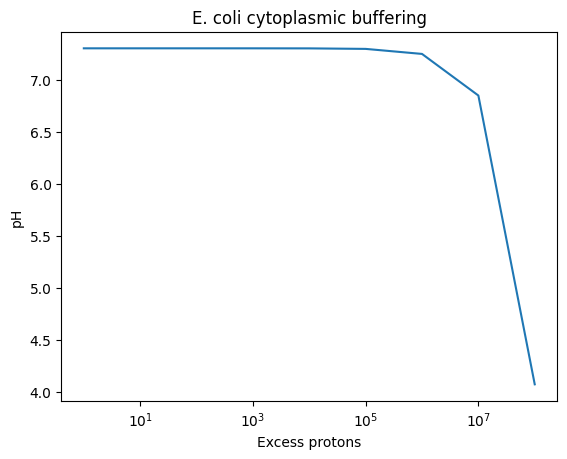

In [24]:
excess_pH = -np.log10(excess_df[('H', 1)])
plt.plot(excess_df.index, excess_pH, label='pH')
plt.title('E. coli cytoplasmic buffering')
plt.xlabel('Excess protons')
plt.ylabel('pH')
plt.xscale('log')
plt.show()

In [25]:
excess_by_mol = {
    'glu': excess[:, 3:7],
    'pi': excess[:, 7:11],
    'gsh': excess[:, 11:16],
    'fru-bp': excess[:, 16:21],
}

pfrac_excess = {}
for mol, concs in excess_by_mol.items():
    # Protonated fraction of site i is the sum of all species j where j <= i,
    # i going most acidic to most basic
    cumtot = np.cumsum(concs, axis=1)
    pfrac_excess[mol] = cumtot[:, :-1]/cumtot[:, -1:]

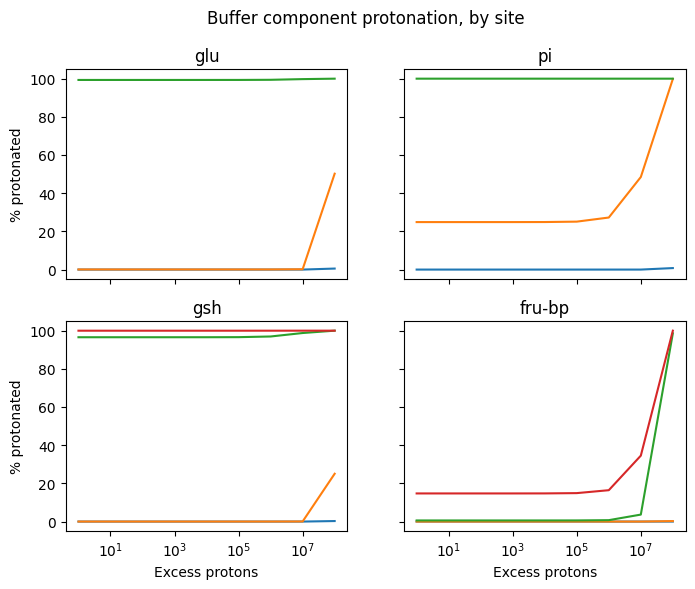

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
panels = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (mol, pfrac) in enumerate(pfrac_excess.items()):
    ax_ = ax[panels[i]]
    for j in range(pfrac.shape[1]):
        ax_.plot(challenges, pfrac[:, j] * 100, label=f'{mol}[{j}]')
    ax_.set_title(mol)
    ax_.set_xscale('log')

ax[1, 0].set_xlabel('Excess protons')
ax[1, 1].set_xlabel('Excess protons')
ax[0, 0].set_ylabel('% protonated')
ax[1, 0].set_ylabel('% protonated')
plt.suptitle('Buffer component protonation, by site')
plt.show()

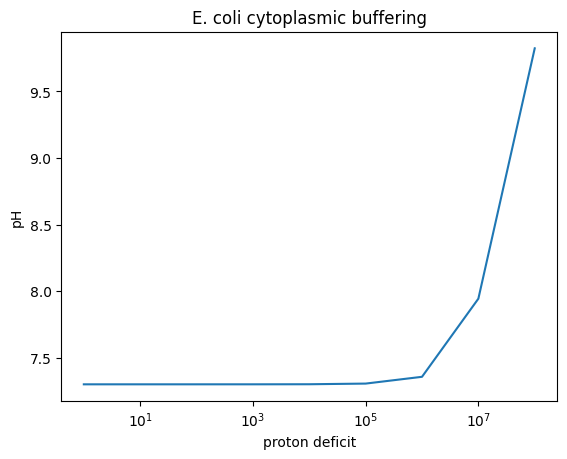

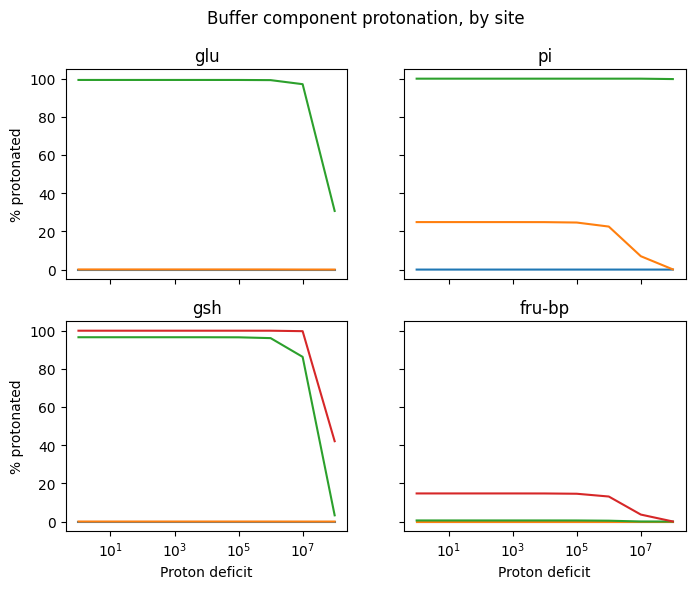

In [27]:
deficit_by_mol = {
    'glu': deficit[:, 3:7],
    'pi': deficit[:, 7:11],
    'gsh': deficit[:, 11:16],
    'fru-bp': deficit[:, 16:21],
}

pfrac_deficit = {}
for mol, concs in deficit_by_mol.items():
    # Protonated fraction of site i is the sum of all species j where j <= i,
    # i going most acidic to most basic
    cumtot = np.cumsum(concs, axis=1)
    pfrac_deficit[mol] = cumtot[:, :-1]/cumtot[:, -1:]
    
deficit_pH = -np.log10(deficit[:, 0])
plt.plot(challenges, deficit_pH, label='pH')
plt.title('E. coli cytoplasmic buffering')
plt.xlabel('proton deficit')
plt.ylabel('pH')
plt.xscale('log')
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
panels = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (mol, pfrac) in enumerate(pfrac_deficit.items()):
    ax_ = ax[panels[i]]
    for j in range(pfrac.shape[1]):
        ax_.plot(challenges, pfrac[:, j] * 100, label=f'{mol}[{j}]')
    ax_.set_title(mol)
    ax_.set_xscale('log')

ax[1, 0].set_xlabel('Proton deficit')
ax[1, 1].set_xlabel('Proton deficit')
ax[0, 0].set_ylabel('% protonated')
ax[1, 0].set_ylabel('% protonated')
plt.suptitle('Buffer component protonation, by site')
plt.show()

## Experiment: Challenge with a pulse of added/removed protons, at varying rates

- Titrate buffer to pH 7.3 (presumed _E. coli_ intracellular)
- Simulate buffer dynamics forward in time with a constant proton supply or drain
- Add or remove 1e6 protons total, over 1 ns, 1μs, 1 ms
    - This time we can drain protons directly, since we're doing it dynamically
- In each case continue the simulation for 1 ms total

In [28]:
buffer = PhBuffer({
    ('glu', +1): [2.10, 4.07, 9.47],
    ('pi', 0): [1.97, 6.82, 12.5],
    ('gsh', +1): [2.12, 3.59, 8.75, 9.65],
    ('fru-bp', 0): [0.89, 1.49, 5.92, 6.52],
})
initial, _ = buffer.titrate(7.3, {('glu', -1): .096, ('pi', -2): .024, ('gsh', -1): .017, ('fru-bp', -4): .015})
y0 = buffer.state_vector(7.3, initial)

proton_onehot = jnp.eye(buffer.s_matrix.shape[0])[0]
total_change = pow(10, 6) * 1e-9  # or just 1e-3 M or 1 mM. Just making it explicit we're adding/removing a million protons.

# Again the class doesn't do this conveniently, so build and integrate the odes manually
def dydt(y, rate):
    return buffer.dydt(y) + proton_onehot * rate
    
fn = jax.jit(dydt)
jac = jax.jit(jax.jacfwd(dydt))

def sim_pulse(rate, width, end):
    t_eval = np.linspace(0, end, 1001)
    switchpoint = int(1000 * width/end) + 1
    # sim1 = scipy.integrate.solve_ivp(
    #     fun=lambda _, y: fn(y),
    #     jac=lambda _, y: jac(y),
    #     y0=y0,
    #     args=(rate,),
    #     t_span=(0, width),
    #     t_eval=t_eval[:switchpoint],
    print((0, width), t_eval[:switchpoint][[0, -1]])
    #     method='BDF',
    #     first_step=1e-9,  # pH is fast
    # )
    # sim2 = scipy.integrate.solve_ivp(
    #     fun=lambda _, y: fn(y),
    #     jac=lambda _, y: jac(y),
    #     y0=y0,
    #     args=(rate,),
    #     t_span=(width, end),
    #     t_eval=t_eval[switchpoint-1:],
    print((width, end), t_eval[switchpoint-1:][[0, -1]])
    #     method='BDF',
    #     first_step=1e-9,  # pH is fast
    # )
    print()

sims = {}
for width in [1e-3, 1e-6, 1e-9]:
    rate = total_change / width
    sim_pulse(rate, width, 1e-3)
    # print(rate, [max(0, total_change - abs(rate) * t) for t in np.linspace(0, .001, 11)])
    # sims[(width, rate)] = scipy.integrate.solve_ivp(
    #     fun=fn,
    #     jac=jac,
    #     y0=y0,
    #     args=(rate, width),
    #     t_span=(0, .001),
    #     t_eval=np.linspace(0, .001, 1001),
    #     method='BDF',
    #     first_step=1e-9,  # pH is fast
    # )    
    # sims[(width, -rate)] = scipy.integrate.solve_ivp(
    #     fun=fn,
    #     jac=jac,
    #     y0=y0,
    #     args=(irate, width),
    #     t_span=(0, .001),
    #     t_eval=np.linspace(0, .001, 1001),
    #     method='BDF',
    #     first_step=1e-9,  # pH is fast
    # )

(0, 0.001) [0.    0.001]
(0.001, 0.001) [0.001 0.001]

(0, 1e-06) [0.e+00 1.e-06]
(1e-06, 0.001) [1.e-06 1.e-03]

(0, 1e-09) [0. 0.]
(1e-09, 0.001) [0.    0.001]

